In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/bats.csv", sep='\t')
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,919144274,64a88778-8de7-4dd0-af39-2d094102cbde,UNIVALLE:ColeccMamif:UV:07186,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Rhinophylla,Rhinophylla pumilio,...,NaN,NaN,CC0_1_0,NaN,Michael Alberico,NaN,NaN,2024-01-24T19:05:08.110Z,NaN,INSTITUTION_MATCH_NONE
1,919144270,64a88778-8de7-4dd0-af39-2d094102cbde,UNIVALLE:ColeccMamif:UV:04296,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Artibeus,Artibeus lituratus,...,NaN,NaN,CC0_1_0,NaN,Michael Alberico,NaN,NaN,2024-01-24T19:05:07.482Z,NaN,COORDINATE_ROUNDED;INSTITUTION_MATCH_NONE
2,919144267,64a88778-8de7-4dd0-af39-2d094102cbde,UNIVALLE:ColeccMamif:UV:07221,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Carollia,Carollia perspicillata,...,NaN,NaN,CC0_1_0,NaN,Omaira Ospina,NaN,NaN,2024-01-24T19:05:08.059Z,NaN,INSTITUTION_MATCH_NONE
3,919144258,64a88778-8de7-4dd0-af39-2d094102cbde,UNIVALLE:ColeccMamif:UV:07565,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Micronycteris,Micronycteris megalotis,...,NaN,NaN,CC0_1_0,NaN,Michael Alberico,NaN,NaN,2024-01-24T19:05:07.706Z,NaN,INSTITUTION_MATCH_NONE
4,919144255,64a88778-8de7-4dd0-af39-2d094102cbde,UNIVALLE:ColeccMamif:UV:07206,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Mesophylla,Mesophylla macconnelli,...,NaN,NaN,CC0_1_0,NaN,Walter Rincón T,NaN,NaN,2024-01-24T19:05:08.069Z,NaN,INSTITUTION_MATCH_NONE


In [3]:
# Taking only the latitude and longitude columns
coords = df[['decimalLatitude', 'decimalLongitude']]
coords

,decimalLatitude,decimalLongitude
0,1.650000,-75.650000
1,-0.596105,-72.404597
2,1.650000,-75.650000
3,1.650000,-75.650000
4,1.650000,-75.650000
...,...,...
4425,-4.215278,-69.940556
4426,-4.215278,-69.940556
4427,-4.215278,-69.940556
4428,-4.215278,-69.940556


In [4]:
coords_unique = coords.drop_duplicates()
coords_unique

,decimalLatitude,decimalLongitude
0,1.650000,-75.650000
1,-0.596105,-72.404597
68,0.515800,-76.495000
69,0.696700,-76.874700
70,-3.773680,-70.381590
...,...,...
4247,-0.400000,-72.283333
4258,-0.180278,-74.774167
4401,-0.050000,-74.666667
4402,-3.770278,-70.383056


In [5]:
print(coords_unique.decimalLatitude.min())
print(coords_unique.decimalLatitude.max())

-4.217972
2.583333


In [6]:
print(coords_unique.decimalLongitude.min())
print(coords_unique.decimalLongitude.max())

-77.166667
-69.505528


In [7]:
coords_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 4403
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   396 non-null    float64
 1   decimalLongitude  396 non-null    float64
dtypes: float64(2)
memory usage: 9.3 KB


In [26]:
# Define the Colombian Amazon extent: latitude ~12°N and ~4°S and between longitudes ~67° and ~79°W.
lat_extent = [12, -4.3]
long_extent = [-79, -67]
# Define the extent coordinates (west, south, east, north)
# west, south, east, north = -79, -4.3, -67, 12
west, south, east, north = -76, -4.5, -67, 5


In [27]:
import rasterio
from rasterio.windows import from_bounds
import os

# Open the raster file
with rasterio.open('data/wc2/wc2.1_2.5m_bio_1.tif') as src:
    
    # Convert geographic coordinates to raster window
    window = from_bounds(west, south, east, north, src.transform)
    
    # Read the data in the window, cropping to the extent
    data = src.read(window=window)
    
    # Directory to save the output files
    output_dir = 'data/wc2/cropped_bioclim'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through each band and write to ASCII
    for i in range(1, src.count + 1):  # This will handle all bands in the raster
        output_path = os.path.join(output_dir, f'bclim{i}.asc')
        with rasterio.open(output_path, 'w', driver='AAIGrid', height=window.height, width=window.width,
                           count=1, dtype=data.dtype, transform=rasterio.windows.transform(window, src.transform)) as dst:
            dst.write(data[i-1], 1)  # Write each band to a new file


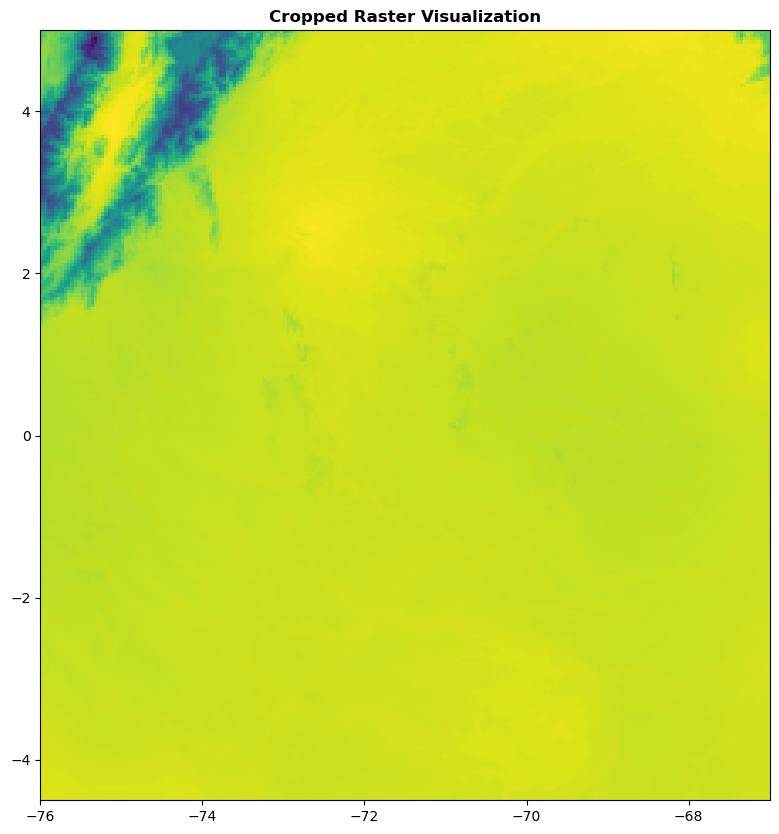

In [28]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Path to the raster file you want to check
file_path = 'data/wc2/cropped_bioclim/bclim1.asc'  # Adjust based on your output files

# Open the raster file
with rasterio.open(file_path) as src:
    # Read the first band (assuming the file is single-band)
    data = src.read(1)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Use rasterio's show method, which handles GeoTransforms correctly
    show(data, ax=ax, transform=src.transform, title='Cropped Raster Visualization')
    plt.show()

In [25]:
import folium

# Map centered around the rough middle of the Colombian Amazon
m = folium.Map(location=[-1.0, -71.0], zoom_start=6)

# Define the boundaries
west, south, east, north = -76, -4.5, -67, 5

# Create a rectangle to represent the extent
folium.Rectangle(
    bounds=[[south, west], [north, east]],
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.2,
).add_to(m)

# Display the map
m


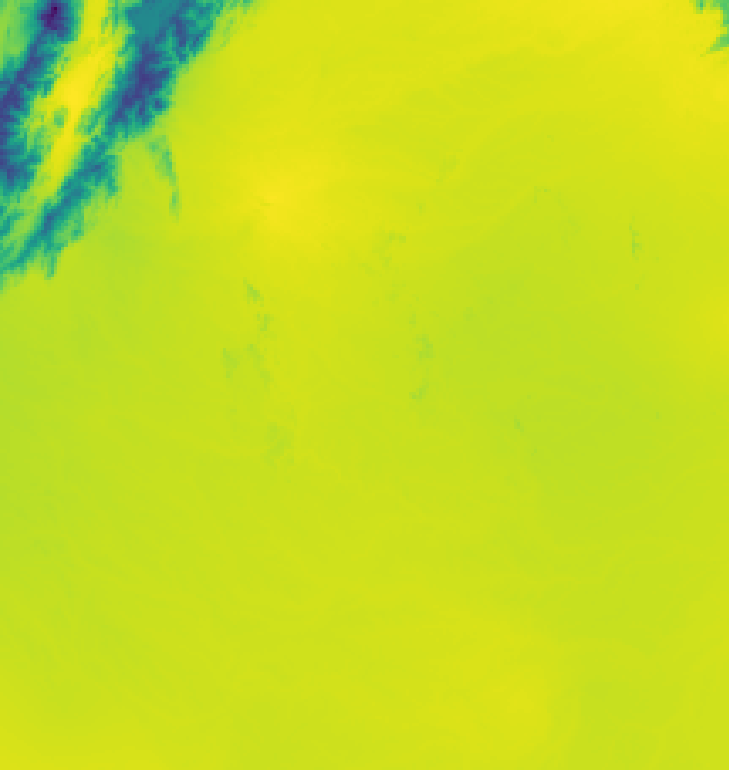

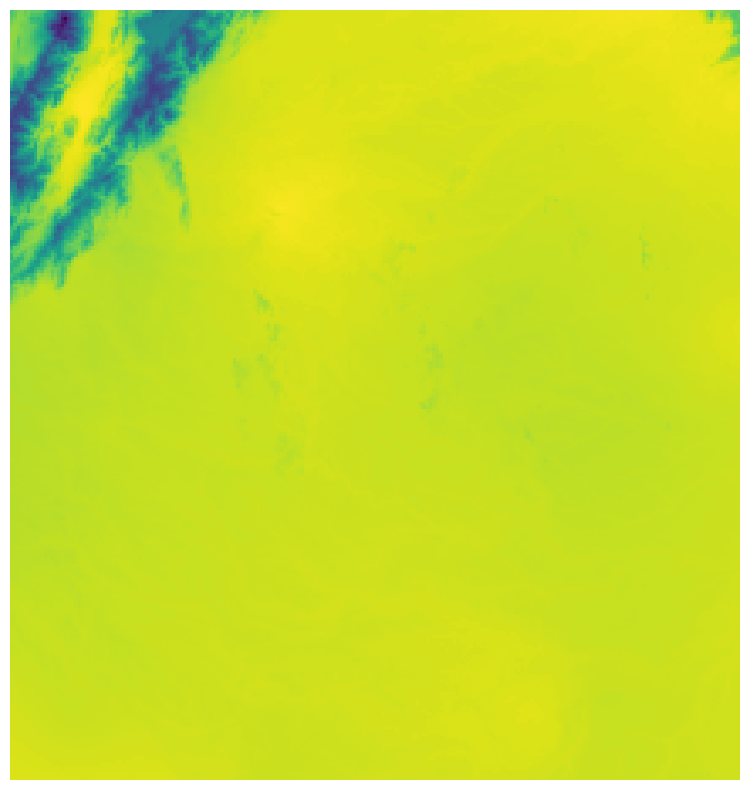

In [30]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from io import BytesIO
import folium
import base64

# Load your raster data
with rasterio.open('data/wc2/cropped_bioclim/bclim1.asc') as src:
    # Make a note of the raster bounds
    bounds = src.bounds
    
    # Read the data (e.g., first band)
    data = src.read(1)
    
    # Normalize the data for better visualization
    data = (data - data.min()) / (data.max() - data.min())
    
    # Create a plot
    fig, ax = plt.subplots(frameon=False, figsize=(10, 10))
    plt.axis('off')
    colormap = plt.cm.viridis  # You can change the colormap to something appropriate for your data
    show(data, ax=ax, cmap=colormap, transform=src.transform, adjust='datalim')
    
    # Save the plot to a PNG image in memory
    img = BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    img.seek(0)
    img_base64 = base64.b64encode(img.read()).decode('utf-8')

# Define the image overlay bounds
image_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

# Create a folium map centered on your data
m = folium.Map(location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2], zoom_start=6)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image='data:image/png;base64,' + img_base64,
    bounds=image_bounds,
    opacity=0.6  # Adjust opacity as needed
).add_to(m)

# Display the map
m


